In [1]:
import os
import pandas as pd
import numpy as np

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import sklearn 

import datetime as dt
from datetime import timedelta 
from datetime import date

# plotting candlestick graphs
import mplfinance as mpf

# used to retrieve ohlc and volume data for a stock from a website
import pandas_datareader.data as web

# import helper file for functions
import helper

Performing quantitative analysis on a growth stock in the technology sector. Here, we'll be taking a look at Shopify, an e-commerce company and how its price has changed over time since its IPO. SHOP, listed on NYSE as well as TSX as (SHOP.TO), had IPO'd on May 21, 2015. 

In [2]:
style.use('ggplot')
# In this stock's case, the stock IPO'd in 2015
start = dt.datetime(2015,5,21)
# latest close date 
latest = date.today()
# retrieve data from Yahoo finance for the given dates
# DataReader is able to parse dates and indexes this column for us.
# otherwise, it'll be necessary to add parse_dates and index_col if reading a csv file.
df = web.DataReader('SHOP','yahoo',start,latest)
# datareader indexes date for us
print (df.tail(6))

                   High         Low         Open        Close   Volume  \
Date                                                                     
2020-08-11  1015.000000  964.739990   999.590027   971.989990  2270900   
2020-08-12  1007.859985  980.000000   983.929993   991.000000  1706400   
2020-08-13  1023.974976  987.000000  1005.000000   999.900024  1401800   
2020-08-14  1007.000000  978.500000  1002.299988   987.900024  1599100   
2020-08-17  1019.640015  995.513977   999.000000  1012.960022  1269100   
2020-08-18  1026.979980  993.169983  1021.000000  1024.709961  1284800   

              Adj Close  
Date                     
2020-08-11   971.989990  
2020-08-12   991.000000  
2020-08-13   999.900024  
2020-08-14   987.900024  
2020-08-17  1012.960022  
2020-08-18  1024.709961  


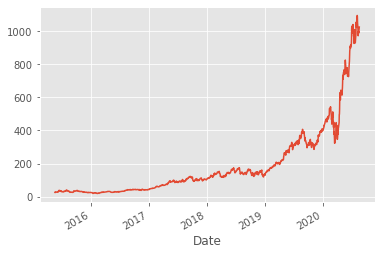

In [3]:
df['Adj Close'].plot()
# plt.show() 

Look at that beautiful curve! 
Since its IPO, SHOP has experienced explosive growth and recently, surpassed RBC on the TSX as the largest publicly listed company. From 17 to just shy of 1100 per share, a 64.7x fold increase since its IPO. 
Alright, let's dive in and do some technical analysis. 
Moving averages are an arithmetic mean of a certain number of data points over a given period of time. 50, 100 and 200 are the most common time periods used for analysis. Its common practice for many technical traders to use these averages to aid in choosing where to enter or exit a position, which then causes these levels to act as strong support or resistance.

Source: Investopedia.com
Note: I don't own any Shopify shares (although I wish I did!)

In [4]:
# Create column for Simple Moving average ('sma') for 100 days
# setting min_periods to 0 which will fill the values in 100d-sma column with close value instead of a NaN
df['100d-sma'] =  df['Adj Close'].rolling(window=100, min_periods=0).mean()
df.tail(100)

,High,Low,Open,Close,Volume,Adj Close,100d-sma
Date,,,,,,,
2020-03-27,433.359985,412.019989,427.609985,421.619995,2569300,421.619995,410.596600
2020-03-30,434.890015,412.010986,423.489990,430.380005,1598800,430.380005,411.821300
2020-03-31,439.589996,414.000000,428.079987,416.929993,1950100,416.929993,413.035600
2020-04-01,406.000000,381.529999,402.989990,384.670013,2272700,384.670013,413.932100
2020-04-02,365.940002,334.549988,350.000000,346.299988,5205500,346.299988,414.537600
...,...,...,...,...,...,...,...
2020-08-12,1007.859985,980.000000,983.929993,991.000000,1706400,991.000000,768.227002
2020-08-13,1023.974976,987.000000,1005.000000,999.900024,1401800,999.900024,774.472102
2020-08-14,1007.000000,978.500000,1002.299988,987.900024,1599100,987.900024,780.051102


We can plot multiple plots into one plot by using subplot, and get the adjusted closing value, the 100 day moving average and trading volume on the same plot. 

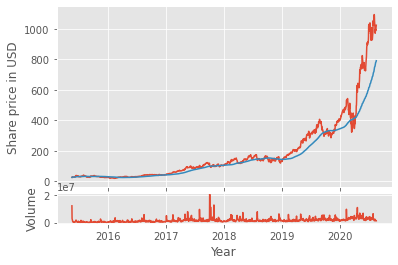

In [5]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100d-sma'])
ax2.plot(df.index, df['Volume'])
ax1.set_title
ax1.set(ylabel='Share price in USD')
ax2.set(ylabel='Volume')
ax2.set(xlabel='Year')

plt.show()

As shown above, the graph shows an exponential rise in share value with the 100 day moving average 

In [6]:
# Creating a candle-stick graph
# If a stock underwent a split, you'd have to create a new dataset based on the Adjusted Close values.
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_vol = df['Volume'].resample('10D').sum()
print (df_ohlc.tail())

                   open         high         low        close
Date                                                         
2020-07-03   986.770020  1040.020020  986.770020  1031.859985
2020-07-13   968.750000  1009.390015  925.489990   957.330017
2020-07-23   928.409973  1053.589966  928.409973  1024.000000
2020-08-02  1083.050049  1094.650024  971.989990   971.989990
2020-08-12   991.000000  1024.709961  987.900024  1024.709961


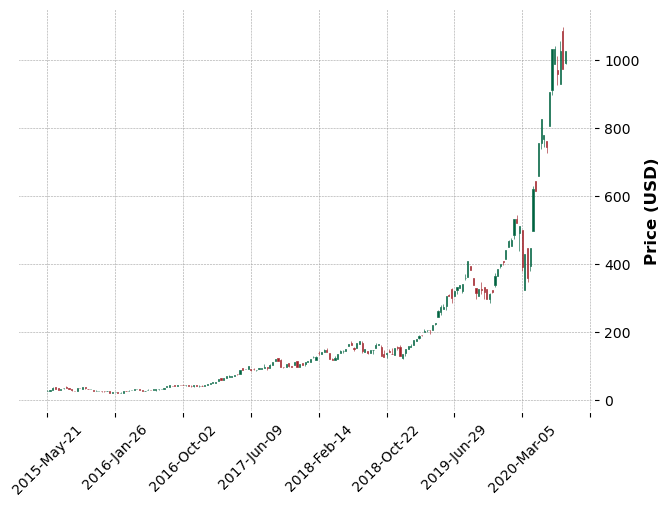

In [7]:
mpf.plot(
    df_ohlc, 
    type='candlestick',
    style='charles',
    ylabel='Price (USD)')


This is just a static candlestick graph that shows all the trading action since 2015. The red candles depict selling of the stock, the green indicates buying. 

Next we're going to attempt to download s&p500 ticker symbols and financial data from yahoo finance api. After downloading the data, we're going to look at the adjusted close values of all the tickers in the index.

In [8]:
# site url
sp500 = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
# retrieve list of company tickers from website, serialize and store data locally
helper.save_index_tickers(sp500)
# setting start date to 10 years ago from today. 
start = dt.datetime.now() - timedelta(days=365)*10
end = dt.datetime.now()
# For now, we'll be overwriting the existing data file on our local with the most recent 10 year data.
helper.get_ticker_financial_data(start,end,'yahoo')
# filepath of data 
fin_data_filepath = os.getcwd() + '\\stock_dfs'
# compile data into a csv file and return name of file
index_adj_close_df_fname = helper.compile_index_data(fin_data_filepath,'sp500')

MMM.csv Currently exists and is upto date
ABT.csv Currently exists and is upto date
ABBV.csv Currently exists and is upto date
ABMD.csv Currently exists and is upto date
ACN.csv Currently exists and is upto date
ATVI.csv Currently exists and is upto date
ADBE.csv Currently exists and is upto date
AMD.csv Currently exists and is upto date
AAP.csv Currently exists and is upto date
AES.csv Currently exists and is upto date
AFL.csv Currently exists and is upto date
A.csv Currently exists and is upto date
APD.csv Currently exists and is upto date
AKAM.csv Currently exists and is upto date
ALK.csv Currently exists and is upto date
ALB.csv Currently exists and is upto date
ARE.csv Currently exists and is upto date
ALXN.csv Currently exists and is upto date
ALGN.csv Currently exists and is upto date
ALLE.csv Currently exists and is upto date
LNT.csv Currently exists and is upto date
ALL.csv Currently exists and is upto date
GOOGL.csv Currently exists and is upto date
GOOG.csv Currently exists 

In [9]:
sp500_df = pd.read_csv(index_adj_close_df_fname)
sp500_df.head()
sp500_df.shape

(2518, 504)

Now that we have the adjusted values of all (most) of the stocks on the S&P 500 index, we can try to get some visualizations going. Let's try getting a heatmap going to visualize the correlations between each ticker symbol.

In [10]:
# Create correlation matrix 
sp500_corr_df = sp500_df.corr()
sp500_corr_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.415614,0.556162,0.933993,0.911329,0.707084,0.840070,0.953021,0.971040,0.964450,...,0.941524,0.067642,0.469988,0.463354,0.960610,0.941350,0.843602,0.946136,0.857832,0.945370
AAL,0.415614,1.000000,0.708336,0.281093,0.174088,0.791804,0.440707,0.343812,0.425260,0.268305,...,0.349689,0.635222,0.783511,0.612960,0.360118,0.433320,0.712573,0.287613,0.617984,-0.219547
AAP,0.556162,0.708336,1.000000,0.532674,0.251248,0.848580,0.543102,0.608800,0.631329,0.521735,...,0.576346,0.424286,0.657455,0.494217,0.480458,0.616080,0.809996,0.571480,0.542836,0.267639
AAPL,0.933993,0.281093,0.532674,1.000000,0.851070,0.689139,0.752228,0.950568,0.942073,0.967670,...,0.851847,-0.115767,0.368655,0.320623,0.852054,0.871717,0.781932,0.952491,0.709533,0.956764
ABBV,0.911329,0.174088,0.251248,0.851070,1.000000,0.611935,0.851124,0.828060,0.888167,0.873152,...,0.755139,-0.309527,0.133186,0.206644,0.901124,0.813342,0.741811,0.818978,0.814969,0.838297


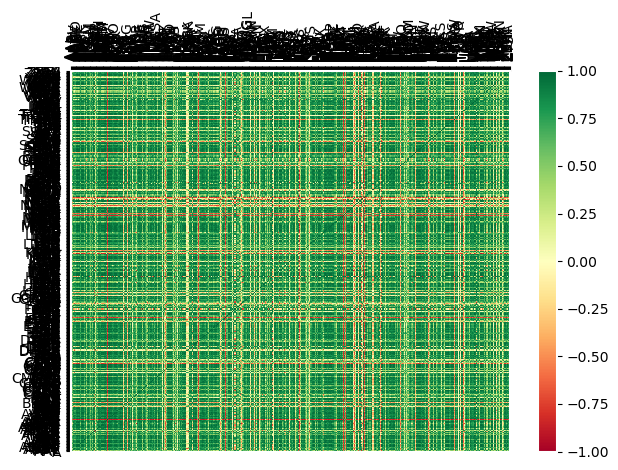

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# generate heatmap with red, yellow, and green showing how closely the securities are related 
heatmap = ax.pcolor(sp500_corr_df, cmap=plt.cm.RdYlGn)
# show range of values based on color in a bar
fig.colorbar(heatmap)
# setting the distance between each security on heatmap axes
ax.set_xticks(np.arange(sp500_corr_df.shape[0]) + 0.5, minor=False)
ax.set_yticks(np.arange(sp500_corr_df.shape[1]) + 0.5, minor=False)
# setting location of ticks to the top of the chart rather than bottom.
ax.xaxis.tick_top()

column_labels = sp500_corr_df.columns
row_labels = sp500_corr_df.index

ax.set_xticklabels(column_labels)
ax.set_yticklabels(row_labels)
plt.xticks(rotation=90)
heatmap.set_clim(-1,1)
plt.tight_layout()
plt.show()

Looks pretty ugly. Creating an interactive version of this heatmap would be useful in looking at specfic groups of securities in the index.

But for now, we're going to take a look at how we can create a classify stocks as a buy, sell or hold by looking at the percent change in its adjusted close values over a given period of time. Let's look at the change in adj close value for the security Apple (AAPL) over the coming 7 days.

In [15]:
data_ = sp500_df.fillna(0, inplace=True)
data_ = sp500_df.columns.values.tolist()
# data_['{}_{}d'.format('AAPL',1)]= (data_['AAPL'].shift(-1)-data_['AAPL'])/data_['AAPL']
data_

# AAPL_pc_change_df = helper.price_delta_label_classifier(sp500_df,'AAPL',7)
# AAPL_pc_change_df.head()

['Date',
 'A',
 'AAL',
 'AAP',
 'AAPL',
 'ABBV',
 'ABC',
 'ABMD',
 'ABT',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AFL',
 'AIG',
 'AIV',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALK',
 'ALL',
 'ALLE',
 'ALXN',
 'AMAT',
 'AMCR',
 'AMD',
 'AME',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'ANET',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'APD',
 'APH',
 'APTV',
 'ARE',
 'ATO',
 'ATVI',
 'AVB',
 'AVGO',
 'AVY',
 'AWK',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BAX',
 'BBY',
 'BDX',
 'BEN',
 'BIIB',
 'BIO',
 'BK',
 'BKNG',
 'BKR',
 'BLK',
 'BLL',
 'BMY',
 'BR',
 'BSX',
 'BWA',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CARR',
 'CAT',
 'CB',
 'CBOE',
 'CBRE',
 'CCI',
 'CCL',
 'CDNS',
 'CDW',
 'CE',
 'CERN',
 'CF',
 'CFG',
 'CHD',
 'CHRW',
 'CHTR',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMA',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COG',
 'COO',
 'COP',
 'COST',
 'COTY',
 'CPB',
 'CPRT',
 'CRM',
 'CSCO',
 'CSX',
 'CTAS',
 'CTL',
 'CTSH',
 'CTVA',
 'CTXS',
 'CV